## Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

## Dataset Loading and Preprocessing

The following code defines a function to load and preprocess the dataset of images. The dataset is assumed to be organized in folders based on the label, where:

- Folder `0` contains images for the **Non-CVD** (non-cardiovascular disease) category.
- Folder `1` contains images for the **CVD** (cardiovascular disease) category.

The `load_data` function performs the following steps:
1. Loads the images from each folder, resizes them to a consistent shape (default size: 224x224 pixels).
2. Appends the image data and corresponding labels to lists.
3. Returns the image data and labels as numpy arrays for use in training a model.

The dataset is then loaded, and the number of images for each category is printed.

In [3]:
# Define dataset path
dataset_path = "data"

# Function to load and preprocess dataset
def load_data(dataset_path, img_size=(224, 224)):
    data, labels = [], []
    for label in [0, 1]:  # 0: Non-CVD, 1: CVD
        folder_path = os.path.join(dataset_path, str(label))
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(data), np.array(labels)

# Load data
data, labels = load_data(dataset_path)
print(f"Loaded {len(data)} images: {np.bincount(labels)}")

Loaded 1118 images: [527 591]


## Display Random Images

The following function `display_random_images` is used to randomly select and display a set of images from the dataset along with their corresponding labels. It helps visualize a sample of the images from both the **Non-CVD** and **CVD** categories.

### Function Overview
- **Inputs**:
  - `data`: The dataset containing the images.
  - `labels`: The labels corresponding to each image (0 for Non-CVD, 1 for CVD).
  - `num_images`: The number of random images to display (default is 5).
- **Process**:
  - Randomly selects the specified number of images from the dataset.
  - Converts each image from BGR to RGB format (since OpenCV uses BGR by default).
  - Displays the images in a single row with their corresponding labels as titles.

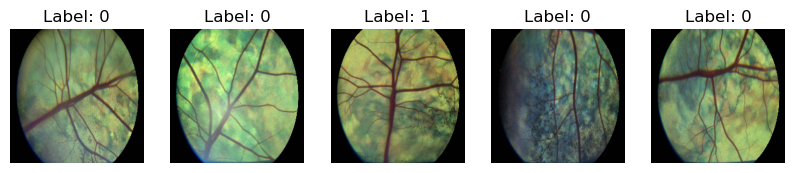

In [5]:
# Display random images
def display_random_images(data, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(data), num_images, replace=False)
    for i, idx in enumerate(indices):
        img = cv2.cvtColor(data[idx], cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {labels[idx]}")
    plt.show()

display_random_images(data, labels)

## Data Normalization and Splitting

In this section, the data is normalized to a range between 0 and 1, which is a common practice for image data preprocessing. The dataset is then split into training and testing sets, with 80% of the data used for training and 20% for testing.

Additionally, the labels are converted into categorical format using **one-hot encoding** to facilitate multi-class classification.

### Steps:
1. **Normalization**: The pixel values of the images are divided by 255 to scale them to the range [0, 1].
2. **Data Split**: The dataset is split into training and testing sets using `train_test_split` with 80% of the data used for training and 20% for testing. The split is stratified to ensure the same distribution of classes in both sets.
3. **Label Conversion**: The labels are converted to categorical format using `to_categorical`, which encodes the labels as binary vectors (one-hot encoding).

In [7]:
# Normalize data and split
data = data / 255.0
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


## Data Augmentation

Data augmentation is a technique used to artificially expand the size of a dataset by generating transformed versions of the existing data. This helps improve the generalization ability of the model, especially when the dataset is small or when overfitting is a concern.

In this case, the `ImageDataGenerator` from Keras is used to apply random transformations to the training images. These transformations include:

1. **Rotation**: Randomly rotating the images within a range of 20 degrees.
2. **Width and Height Shifting**: Randomly shifting the images along the width and height by 20%.
3. **Shearing**: Applying shear transformations by a factor of 20%.
4. **Zooming**: Randomly zooming in or out on the images by a factor of 20%.
5. **Horizontal Flipping**: Randomly flipping the images horizontally.

These augmentations will help create a more diverse training dataset and improve the model's ability to generalize.

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

## Building the CNN Model

In this section, a Convolutional Neural Network (CNN) model is built using the Keras Sequential API. The model architecture is designed to classify images into two categories: **Non-CVD** (0) and **CVD** (1).

### Model Architecture:
1. **Convolutional Layers**:
   - The model starts with three convolutional layers with increasing numbers of filters (32, 64, and 128).
   - Each convolutional layer uses a **3x3 kernel** and **ReLU activation** to learn spatial features from the images.
   
2. **Max-Pooling Layers**:
   - After each convolutional layer, a **2x2 max-pooling layer** is applied to downsample the feature maps and reduce spatial dimensions.

3. **Fully Connected Layers**:
   - The output of the final convolutional block is flattened into a 1D vector.
   - A **Dense layer** with 256 neurons and **ReLU activation** is added to learn higher-level representations.
   - A **Dropout layer** with a rate of 0.5 is used to prevent overfitting.

4. **Output Layer**:
   - The final layer consists of **2 neurons** (one for each class: CVD and Non-CVD), using a **softmax activation** function for multi-class classification.

### Model Compilation:
- The **Adam optimizer** with a learning rate of 0.0001 is used for optimization.
- The loss function is set to **categorical crossentropy** since it's a multi-class classification problem.
- The metrics used to evaluate the model include **accuracy**, **precision**, **recall**, and **AUC**.

In [11]:
# Build CNN model
def create_model(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

model = create_model()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)



C:\Users\Smrit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Callbacks

Callbacks are functions that are executed at certain stages during training. They allow for real-time adjustments to the training process, such as early stopping or learning rate adjustments.

In this section, two callbacks are defined:

1. **Early Stopping**:
   - Monitors the **validation loss** (`val_loss`) during training.
   - If the validation loss does not improve for 5 consecutive epochs (`patience=5`), the training is stopped early to prevent overfitting.
   - The model will revert to the weights from the epoch with the best validation loss.

2. **Learning Rate Reduction**:
   - Monitors the **validation loss** (`val_loss`) during training.
   - If the validation loss does not improve for 3 consecutive epochs (`patience=3`), the learning rate is reduced by a factor of 0.5 (`factor=0.5`).
   - This can help the model converge more smoothly when training plateaus.

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

## Model Training

In this section, the model is trained using the augmented training data provided by the `ImageDataGenerator`. The training process includes the following:

1. **Data Augmentation**: The training images are fed to the model via the `datagen.flow()` method, which applies the data augmentation transformations defined earlier. This helps improve the generalization of the model.
2. **Validation**: The model is validated on the test set (`X_test`, `y_test`) after each epoch.
3. **Epochs**: The model is trained for a maximum of 30 epochs.
4. **Callbacks**: The **EarlyStopping** and **ReduceLROnPlateau** callbacks are used to prevent overfitting and adjust the learning rate if the validation loss stops improving.


In [15]:
# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

C:\Users\Smrit\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - AUC: 0.4869 - Precision: 0.4681 - Recall: 0.4681 - accuracy: 0.4681 - loss: 0.7236 - val_AUC: 0.6366 - val_Precision: 0.5759 - val_Recall: 0.5759 - val_accuracy: 0.5759 - val_loss: 0.6808 - learning_rate: 1.0000e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 978ms/step - AUC: 0.6054 - Precision: 0.5689 - Recall: 0.5689 - accuracy: 0.5689 - loss: 0.6786 - val_AUC: 0.6640 - val_Precision: 0.6250 - val_Recall: 0.6250 - val_accuracy: 0.6250 - val_loss: 0.6652 - learning_rate: 1.0000e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - AUC: 0.5697 - Precision: 0.5541 - Recall: 0.5541 - accuracy: 0.5541 - loss: 0.6843 - val_AUC: 0.6646 - val_Precision: 0.6205 - val_Recall: 0.6205 - val_accuracy: 0.6205 - val_loss: 0.6510 - learning_rate: 1.0000e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - AUC: 0.6008 - Precision: 0.5643 - Recall: 0.5643 - accuracy: 0.5643 - loss: 0.6769 - val_AUC: 0.6662 - val_Precision: 0.6250 - val_Recall: 0.

## Plotting the Training History

After training the model, it is important to visualize its performance to understand how well the model is learning and how it generalizes to unseen data. In this section, we plot the **training accuracy**, **validation accuracy**, **training loss**, and **validation loss** over the epochs.


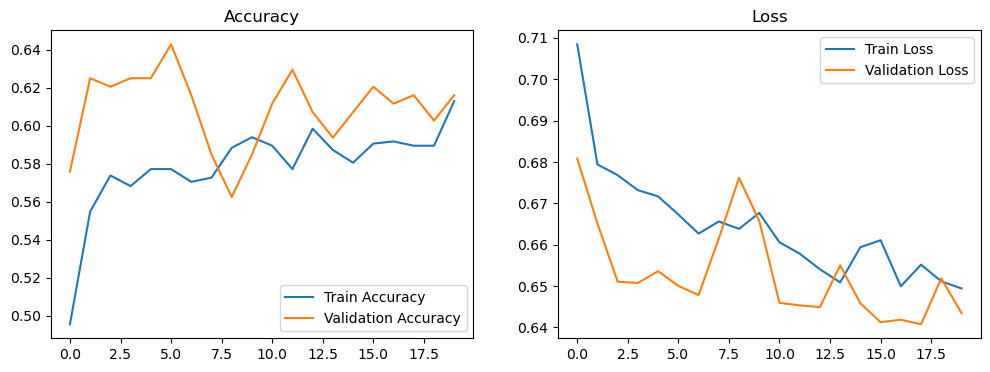

In [39]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_training_history(history)

## Plotting the Confusion Matrix

A confusion matrix is a useful tool for evaluating the performance of a classification model. It shows the counts of **True Positives**, **True Negatives**, **False Positives**, and **False Negatives**. This allows for a better understanding of where the model is making errors.

In this section, the confusion matrix is computed using the predicted labels and true labels from the test data, and the matrix is visualized using a heatmap.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


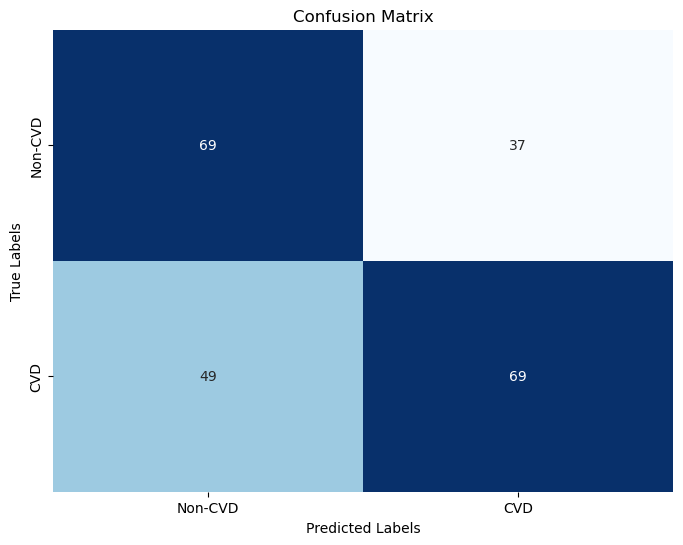

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_true, y_pred, labels=['Non-CVD', 'CVD'])

## Classification Report

The **classification report** provides a detailed evaluation of the classification model's performance. It includes metrics such as **precision**, **recall**, **f1-score**, and **support** for each class. These metrics help assess how well the model performs for each class, which is especially useful for imbalanced datasets.

In [44]:
# Classification Report
def display_classification_report(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    styled_report = df_report.style.background_gradient(cmap="viridis", subset=['precision', 'recall', 'f1-score'])
    return styled_report

styled_report = display_classification_report(y_true, y_pred, target_names=['Non-CVD', 'CVD'])
styled_report

,precision,recall,f1-score,support
Non-CVD,0.584746,0.650943,0.616071,106.000000
CVD,0.650943,0.584746,0.616071,118.000000
accuracy,0.616071,0.616071,0.616071,0.616071
macro avg,0.617845,0.617845,0.616071,224.000000
weighted avg,0.619618,0.616071,0.616071,224.000000


## Save the Model

Once the model is trained, it is essential to save it for future use, such as for inference or further training. This can be done using the `model.save()` method in Keras, which saves the model architecture, weights, and training configuration.


In [48]:
# Save the model
model.save('model.h5')  # or model.save('model_filename')

# Print confirmation message
print("Model saved successfully as 'model_filename.h5'")

Model saved successfully as 'model_filename.h5'


In [50]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,735,560 (254.58 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,490,374 (169.72 MB)